## SSM implementation, 2 tasks (testing)

TEST - lily

#### general notes

- time series model (note for matplotlib animate visualization)
- "model" how a state space evolves over time
- each discrete time step ∆t corresponds to 1 input data (-> step method)


### prof suggestions

- tweak the $A$ matrix (i.e. padding certian positions with 0 to see which structures are more important than others, or pad 0s at 1,1, or n,n positions of the matrix to see something about long-range dependency)
- possibly include stuff on matrix conditioning? (perfectly-conditioned matrix = unitary)

#### other notes

- explore how linear dynamics/physical systems are reflected by the SSM (S4)
- maybe tweaking $A$ will give us a general idea of how RNN is different from SSM
- if time permits, implement RNN from scratch and explain how the hidden state is processed diffferently (time did not permit lol)

Daniel from gc:
- ...it is similar in format from an RNN except the hidden matrix in RNN is non linear and only trained by gradient descent, whereas state space model like reflects linear dynamics / a more physical system and is more structured 

---
## Prev-Bit Task

In [163]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from Training.generator_prevbit import make_train_test
from SSM.model import SimpleSSM
from sklearn.metrics import accuracy_score

#### Model implementation

possible thigsn to cover idk:
- classification
- sklearn metrics
- dimensionality reduction
- cross-validation
- hyperparameter tuning


In [164]:
# hyperparameters
n_train = 1000
n_test = 200
T = 30  # sequence length (baseline T, increase for more "noise")
state_dim = 8

# get train/test data
x_train, y_train, x_test, y_test = make_train_test(n_train=n_train, n_test=n_test, T=T)

In [165]:
# implementation

model = SimpleSSM(state_dim=state_dim, input_dim=1, output_dim=1, learn_A=True)

# training loop
n_epoch = 10
lr = 1e-2
train_losses = []

for epoch in range(n_epoch):
    total_loss = 0

    for i in range(n_train):
        u = x_train[i]          # shape (T, 1)
        target = y_train[i]     # shape (T, 1)

        loss, grads = model.loss_and_grads(u, target)
        model.step(grads, lr=lr)
        total_loss += loss

    avg_loss = total_loss / n_train
    train_losses.append(avg_loss)

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.6011
Epoch 2, Loss: 0.1784
Epoch 3, Loss: 0.0715
Epoch 4, Loss: 0.0592
Epoch 5, Loss: 0.0551
Epoch 6, Loss: 0.0530
Epoch 7, Loss: 0.0517
Epoch 8, Loss: 0.0509
Epoch 9, Loss: 0.0502
Epoch 10, Loss: 0.0498


In [166]:
# evaluate model on test data
test_loss = 0
test_losses = []

for i in range(n_test):
    u = x_test[i]
    target = y_test[i]
    loss,_ = model.loss_and_grads(u, target)    # only need loss
    # print(loss)
    test_losses.append(loss)
    test_loss += loss

print(f'Test loss: {test_loss / n_test:.4f}')

Test loss: 0.0512


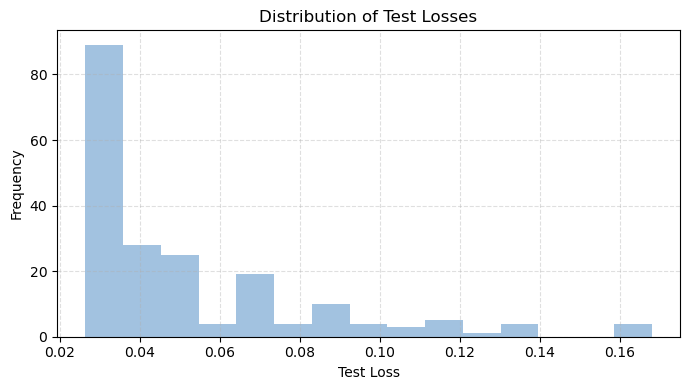

In [167]:
plt.figure(figsize=(7, 4))
plt.hist(test_losses, bins=15, color="#A2C2E0")
plt.title("Distribution of Test Losses")
plt.xlabel("Test Loss")
plt.ylabel("Frequency")
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

Could possibly use the hist plot -> evaluate generalization

Most predictions are accurate - low loss -> predicted outputs were close to actual targets

only a few test cases were harder for the model and gave higher error (rightmost bars)

overall good result. model perfoms well on most test data

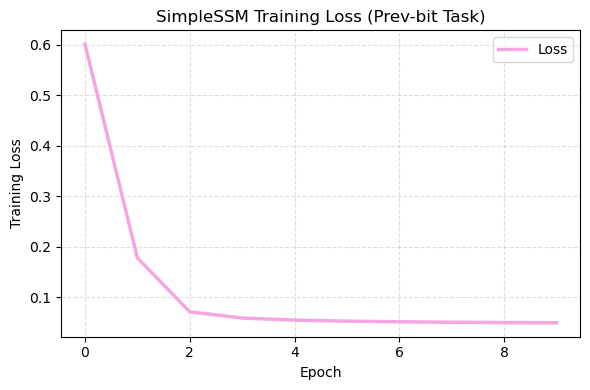

In [168]:
# visualziatoin

plt.figure(figsize=(6,4))
plt.plot(train_losses, color='#F5A6E1', linewidth=2.5, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('SimpleSSM Training Loss (Prev-bit Task)')
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()

extra for visualization: see how well our model performs on random test sequence

In [169]:
from SSM.helpers import sigmoid

idx = np.random.randint(0, len(x_test))
input_seq = x_test[idx]
target_seq = y_test[idx]
pred_logits, _ = model.forward(input_seq)
pred_seq = (sigmoid(pred_logits) > 0.5).astype(int)

print("Input:\n", input_seq.ravel().astype(int))
print("Target:\n", target_seq.ravel().astype(int))
print("Pred:\n", pred_seq.ravel())
print(f'\naccuracy: {accuracy_score(pred_seq.ravel(),target_seq.ravel().astype(int)):.2%}')

print('\npretty good!')

Input:
 [1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1]
Target:
 [1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1]
Pred:
 [0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1]

accuracy: 96.67%

pretty good!


Concluding notes for this task:
- this model can learn a linear dynamical system with structured memory (HiPPO/S4-inspired)
- SSMs like this model can retain info across time, even w/ simple architecture and no RNN/attenuation layers
- prev-bit success => evidence that our model encodes recent history into its hidden state using the SSM matrices

---
## Memory Copy Task - WORK IN PROGRESS, messed up somwhere

Notes: for this task mybe make a new method in SimpleSSM model, probably smth like MSE for loss in the `loss_and_grad` method 

because the losses were lookin wonky

In [170]:
from Training.generator_memory import generator

In [171]:
# hyperparameters
n_train = 10000
n_test = 1000
n = 10  # length of sequence to memorize (default 10)
g = 10  # time lag before recall (default 10)
seed = 0

# generate data
train_data = generator(n=n, g=g, n_data=n_train, seed=seed)
x_train, y_train = train_data.seq()

test_data = generator(n=n, g=g, n_data=n_test, seed=seed+1)
x_test, y_test = test_data.seq()

# reshape data
x_train = x_train[..., np.newaxis]  # (10000, T, 1)
y_train = y_train[..., np.newaxis]

x_test = x_test[..., np.newaxis]
y_test = y_test[..., np.newaxis]

In [ ]:
# bad - fix tmw

# initialize model
from SSM.model import SimpleSSM

model = SimpleSSM(state_dim=64, input_dim=1, output_dim=1, dt=1.0)

# training loop
n_epoch = 10
lr = 1.0e-2
train_losses = []

for epoch in range(n_epoch):
    total_loss = 0

    for i in range(len(x_train)):
        u = x_train[i]
        target = y_train[i]
        loss, grads = model.loss_and_grads_mse(u, target)
        model.step(grads, lr=lr)
        total_loss += loss

    avg_loss = total_loss / len(x_train)
    train_losses.append(avg_loss)
    
    print(f'Epoch {epoch+1}, Train loss: {avg_loss:.4f}')

Epoch 1, Train loss: 399122.8382
Epoch 2, Train loss: 403938.3022
Epoch 3, Train loss: 0.2679
Epoch 4, Train loss: 0.0890
Epoch 5, Train loss: 0.0670
Epoch 6, Train loss: 0.0571
Epoch 7, Train loss: 0.0480
Epoch 8, Train loss: 0.0297
Epoch 9, Train loss: 0.0027
Epoch 10, Train loss: 0.0000


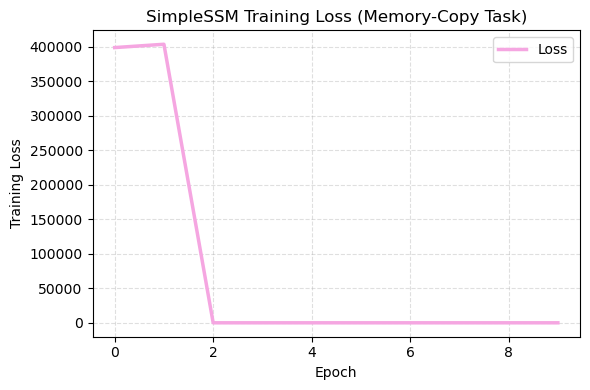

In [ ]:
# bad - fix tmw

plt.figure(figsize=(6,4))
plt.plot(train_losses, color='#F5A6E1', linewidth=2.5, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('SimpleSSM Training Loss (Memory-Copy Task)')
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()

In [174]:
# eval on test set

test_loss = 0

for i in range(len(x_test)):
    u = x_test[i]
    target = y_test[i]
    loss, _ = model.loss_and_grads(u, target)
    test_loss += loss
test_loss /= len(x_test)
print(f'Test loss: {test_loss:.4f}')

Test loss: -6.6227


In [175]:
idx = np.random.randint(0, len(x_test))

input_seq = x_test[idx].squeeze().astype(int)
target_seq = y_test[idx].squeeze().astype(int)
pred_logits, _ = model.forward(x_test[idx])
pred_seq = np.round(pred_logits).astype(int).squeeze()

print("Input:   ", input_seq.tolist())
print("Target:  ", target_seq.tolist())
print("Predicted:", pred_seq.tolist())

print(f'Accuracy: {accuracy_score(pred_seq.tolist(), target_seq.tolist())}')

print('\ngood for shorter sequence lengths, accuracy approaches 0.5 for longer seq lengths')

Input:    [5, 2, 8, 7, 1, 5, 2, 6, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 8, 7, 1, 5, 2, 6, 1, 5]
Predicted: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 8, 7, 1, 5, 2, 6, 1, 5]
Accuracy: 1.0

good for shorter sequence lengths, accuracy approaches 0.5 for longer seq lengths


---
#### Model visualization

ideas to start off w/ (in-progress):

- plot loss function over iterations
- visualize parameter updates
- matplotlib/seaborn
    - attention heatmaps (extract attension weights from model + plot)
- Model architecture/internal states
    - Inspectus: used for ML visualization, explore model internals
    - or just matplotlib (e.g. check activation patterns across model layers/components)
- efficiency-focused visualizations
    - LTSF-Linear: visualization of weights after training, get insight to predicted values
    - OptimusPy: (check what this is)
    - PPT (Token Pruning & Pooling Transformers): (check what this is)

NOTE: We could do similar thing as Gu's Figure 2 (trained S4 model on LRA Path-X, where SSM convolution kernels are reshaped into a 128x128 image)